# Download Data

## Metadata
Using the [Sketchfab API](https://docs.sketchfab.com/data-api/v3/index.html#!/models/get_v3_models_uid_download), I queried the Sketchfab site and downloaded metadata describing more than thousand 3D-models, by querying Sketchfab for existing 3D-model collections and compiling new collections on [my Sketchfab account](https://sketchfab.com/alvarosaurus/collections). The Sketchfab API provides data in JSON format.

In [1]:
import json
import requests
from requests.exceptions import RequestException
import pandas as pd
from pandas.io.json import json_normalize
import os

#Sketchfab API
#https://docs.sketchfab.com/data-api/v3/index.html#!/models/get_v3_models_uid_download
#(does not require an API key)
SKETCHFAB_API_URL = 'https://api.sketchfab.com/v3' # Sketchfab.com API URL

# Neolithic culture, based on the example of the settlement in Bylany near Kutná Hora,
# Linear Pottery Culture (LBK)
# Archaeological 3D virtual museum, Prague, Czech Republic 
# https://sketchfab.com/archaeo3d/collections/kultura-s-linearni-keramikou-lbk-nadoby
BYLANY_LBK_COLLECTION_URI = 'c122b58e1ed449d4ac032d4b2a434f24' 

# Neolithic culture, based on the example of the settlement in Bylany near Kutná Hora,
# Stroked Pottery culture (SBK)
# Archaeological 3D virtual museum, Prague, Czech Republic 
# https://sketchfab.com/archaeo3d/collections/kultura-s-vypichanou-keramikou-sbk-nadoby
BYLANY_SBK_COLLECTION_URI = '62179eea153049c5b63d6b4018a6ac6f' 

# Prehistory - Collection Siret, Bronze Age
# The Royal Museums of Art and History, Brussels
# https://sketchfab.com/kmkg-mrah/collections/prehistory-collection-siret
SIRET_COLLECTION_URI = 'de9f33f04a4d45bd825a7e2edfc5739a' 

# Iron Age pottery training set
# Personal collection on my Sketchfab account
# https://sketchfab.com/alvarosaurus/collections/iron-age-pottery-training-set
IRON_AGE_COLLECTION_URI = 'fc4a397de4554544a0ed0f745c0ca849'

# Greek pottery training set
# Personal collection on my Sketchfab account
# https://sketchfab.com/alvarosaurus/collections/greek-pottery-training-set
GREEK_COLLECTION_URI = '34ff128d81ce4b90954bffb0b52dfbc3'

# Roman pottery training set
# Personal collection on my Sketchfab account
# https://sketchfab.com/alvarosaurus/collections/roman-pottery-training-set
ROMAN_COLLECTION_URI = '1052b6751ddb4fdf942dc0f17aed38ab'


def list_models(next_cursor, collection_uri):
    """Download one page of json list of models."""
    endpoint = '{}/collections/{}/models?cursor={}'.format(SKETCHFAB_API_URL, collection_uri, next_cursor) # models in collection API endpoint (GET)        
    response = requests.get(endpoint)
    data = response.json()
    return data['results'], data['cursors']['next']

def read_collection(collection_uri):
    """List all models in collection, paginate, store models in data frame"""
    results, next_cursor = list_models(None, collection_uri)
    results_df = json_normalize(results)
    while(next_cursor):
        # get next paginated results, append to data frame
        results, next_cursor = list_models(next_cursor, collection_uri)
        results_df = results_df.append(json_normalize(results), sort=True) # parse json result
    return results_df

collections = [BYLANY_LBK_COLLECTION_URI, BYLANY_SBK_COLLECTION_URI, SIRET_COLLECTION_URI, IRON_AGE_COLLECTION_URI, GREEK_COLLECTION_URI, ROMAN_COLLECTION_URI]

# List all models in all collections
collection_df = None
for collection in collections:
    result_df = read_collection(collection) # read collection from Sketchfab API
    if collection_df is None:
        collection_df = result_df
    else:
        collection_df = collection_df.append(result_df, sort=True)

# save the original data to file
collection_df.to_csv(os.path.join('data', 'downloaded_metadata.csv'), index=False)

Each 3D-model of an object can be characterized by a number of metadata attributes. I dropped those attributes which are not relevant to the project.

In [2]:
import pandas as pd
import os

# reload the original data
collection_df = pd.read_csv(os.path.join('data', 'downloaded_metadata.csv'), index_col=False)

# drop not relevant columns 
metadata_df = collection_df.drop(
    ['collectedAt', 'uid','publishedAt', 'createdAt', 'isDownloadable', 'isProtected', 'categories',
     'staffpickedAt', 'viewCount', 'likeCount', 'animationCount', 'soundCount', 'embedUrl', 'commentCount', 'isAgeRestricted', 'price', 
     'user.avatar.uid', 'user.avatar.uri', 'user.avatar.images', 'user.account', 'user.username', 'user.uri', 'user.uid', 
     'license.uri', 'license.requirements', 'license.label', 'license.slug', 'license.url', 'thumbnails.images', 'faceCount'], axis=1)

The attributes relevant to the project are:
* the name of the 3D model
* ideally a textual description of the object, written by a museum curator
* the API-URI where the 3D-model file can be downloaded
* a link to the 3D-model's preview page on Sketchfab
* the name of the museum, institution or organization that provided the digitized object
* a link to the providers page on Sketchfab
* the license of the 3D-model
* the number of vertices in the 3D-model
* tags added by the provider of the 3D-model describing the object (json)

### Object id's

I added a unique identifier to each object, extracted from the 3d-model's URI.

In [3]:
# Add a unique ID to each object
metadata_df['id'] = [uri.split('/')[-1] for uri in metadata_df.uri]

# drop duplicates 
metadata_df = metadata_df.drop_duplicates(subset='uri', keep='first')

### Added classes for period / culture

I labeled each object according to its archaeological period and/or culture. The archaeological period was extracted from name, description or tags, using regular expressions. 
Classes are assumed to be non-overlapping (this is not unambiguously true, of course, but it's the working assumption).

In [4]:
import numpy as np
import re

metadata_df['period'] = np.empty(len(metadata_df), dtype=object)
# make sure descriptions exist, replace by empty string if not
idx = metadata_df['description'].isna()
metadata_df.loc[idx, 'description'] = ''

def parse_period(df, expression, period):
    regexp = re.compile(expression, re.IGNORECASE)
    id_name = np.array([regexp.search(name) is not None for name in df.name])
    id_description = np.array([regexp.search(desc) is not None for desc in df.description])
    id_tags = np.array([regexp.search(tag) is not None for tag in df.tags])
    idx = id_name | id_description | id_tags
    df.loc[idx, 'period'] = period

parse_period(metadata_df, 'LBK|starolineární', 'Neolithic Linear Pottery Culture (LBK)') # starolineární = "old linear" in Czech
parse_period(metadata_df, 'SBK', 'Neolithic Stroked Pottery culture (SBK)')
parse_period(metadata_df, 'Bronze Age|Siret', 'Bronze Age') # Siret is a collection of Spanish Bronze Age pots 
parse_period(metadata_df, 'Iron Age|Iron-age|Ibera|Ibero|Talayotic|Celtic|Dacic|Visigoth|järnåldern', 'Iron Age') # Various Iron Age cultures
parse_period(metadata_df, 'Roman|Romein', 'Roman') # Romein = "Roman" in Dutch
# Athen, Attic and Corinthian are classical-period Greek genres, 
# Aidone is a city in Sicily of Greek origin, 
# Apulia is a region in south Italy wich was a Greek colony during antiquity
parse_period(metadata_df, 'Greek|Greece|Grèce|Greco|griego|griega|Griekenland|Athen|Attic|Corinth|corintio|Aidone|Apulia|Apulien', 'Greek') 

I cleaned up the dataset and removed: 
* objects that could not be classified into any of the periods above

In [5]:
# drop entries for which no period could be determined
idx = metadata_df.period.isna()
metadata_df = metadata_df[~idx]

Additionally, I used regular expressions to detect and remove:
* objects that are not ceramics, i.e. a piece of bone, stone or a shell, 
* object fragments or "sherds"
* reproductions 

In [6]:
import re

# Remove objects that are not ceramics, i.e. a piece of bone, stone or a shell

# Add a boolean column indication whether something else than pottery
regexp = re.compile(r'stone|bone|shell|limpet', re.IGNORECASE)
idx = [regexp.search(name) is not None for name in metadata_df.name]
metadata_df['other.material'] = idx
metadata_df['other.material'] = metadata_df['other.material'].astype('bool')
# remove items, based on the column values
idx = metadata_df['other.material']
metadata_df = metadata_df[~idx]
# drop the extra column
metadata_df.drop(['other.material'], axis=1, inplace=True)

# Is it a piece of a broken object? a reproduction?

# Add a boolean column indication whether a piece of a broken object, or a reproduction
regexp = re.compile(r'shard|sherd|fragment|Foot of|base of|half|reproduction|scherf', re.IGNORECASE)
idx = [regexp.search(name) is not None for name in metadata_df.name]
metadata_df['fragment'] = idx
metadata_df['fragment'] = metadata_df['fragment'].astype('bool')
# remove items, based on the column values
idx = metadata_df.fragment
metadata_df = metadata_df[~idx]
# drop the extra column
metadata_df.drop(['fragment'], axis=1, inplace=True)

print('The cleaned up dataset has {} objects.'.format(metadata_df.shape[0]))

The cleaned up dataset has 1020 objects.


I changed the order of the columns (for readibility).

_Table 1: Example data_

In [7]:
# change order of columns
metadata_df = metadata_df.loc[:, ['id', 'name', 'description', 'period', 'uri', 'viewerUrl', 'user.displayName', 'user.profileUrl', 'license.fullName', 'vertexCount', 'tags']]
metadata_df.head(3)

,id,name,description,period,uri,viewerUrl,user.displayName,user.profileUrl,license.fullName,vertexCount,tags
0,a049baa005da476bb7ffe1df5e6b4f78,2000020,Id 2000020. Polokulovitá nádoba s oblou horní ...,Neolithic Linear Pottery Culture (LBK),https://api.sketchfab.com/v3/models/a049baa005...,https://sketchfab.com/3d-models/2000020-a049ba...,Archaeological 3D virtual museum,https://sketchfab.com/archaeo3d,Creative Commons Attribution,245002,[]
1,836630c9eb6344878f5b3e72aaa37f8b,2001130,Id 2001130. Miska s rovným okrajem. Kultura LB...,Neolithic Linear Pottery Culture (LBK),https://api.sketchfab.com/v3/models/836630c9eb...,https://sketchfab.com/3d-models/2001130-836630...,Archaeological 3D virtual museum,https://sketchfab.com/archaeo3d,Creative Commons Attribution,245002,[]
2,77d11d8ec01e424e829b9914c388b0a1,2002770,Id 2002770. Část láhve. Kultura LBK (2c). Kont...,Neolithic Linear Pottery Culture (LBK),https://api.sketchfab.com/v3/models/77d11d8ec0...,https://sketchfab.com/3d-models/2002770-77d11d...,Archaeological 3D virtual museum,https://sketchfab.com/archaeo3d,Creative Commons Attribution,249998,[]


## Metadata EDA

### Objects by data provider

The 3D-models were contributed to Sketchfab by various institutions (tab. 2). 

In [8]:
counts = metadata_df['user.displayName'].value_counts() # user.displayName are the names of the data providers
# data providers with more than 10 objects 
idx = counts >= 10
# data providers with less than 10 objects
other_names = counts[~idx].keys()
idx_other = [name in other_names for name in metadata_df['user.displayName']]
metadata_df.loc[idx_other, 'user.displayName'] = 'Other (less than 10 models each)' # replace name by "other ..."
counts = metadata_df['user.displayName'].value_counts() # user.displayName are the names of the data providers
counts_df = pd.DataFrame(counts).reset_index(level=0).rename(columns={'index':'Provider', 'user.displayName': 'Object count in the dataset'})
idx_other = counts_df['Provider'] == 'Other (less than 10 models each)'
# put "other..." at the end of the data frame
other_counts = counts_df[idx_other]
counts_df.drop(other_counts.index, inplace=True)
counts_df = counts_df.append(other_counts)
counts_df

,Provider,Object count in the dataset
0,Archaeological 3D virtual museum,369
1,The Royal Museums of Art and History,343
2,Global Digital Heritage,180
4,Institutul Național al Patrimoniului,22
5,CMPLab,11
6,UVA3D,10
3,Other (less than 10 models each),85


### Number of items per class

The number of items per class is imbalanced, as LBK and Bronze Age items are more numerous than the others.

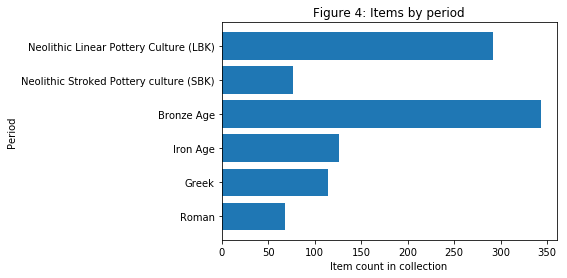

In [9]:
import matplotlib.pyplot as plt

# count items by period
counts = metadata_df['period'].value_counts()
# periods in chronological order
antiquity = [
    'Neolithic Linear Pottery Culture (LBK)', 'Neolithic Stroked Pottery culture (SBK)', 
    'Bronze Age', 'Iron Age', 'Greek', 'Roman']
counts = counts.reindex(antiquity).iloc[::-1] # reverse order top to bottom
# horizontal bar plot
plt.barh(counts.index, counts)
plt.xlabel('Item count in collection')
plt.ylabel('Period')
plt.title('Figure 4: Items by period')
plt.show();

### Classes per data provider

Additionally, each data provider has a different combinations of data classes: "The Royal Museums of Art and History" provides only data for the Bronze Age class, while "Global Digital Heritage" provides data for the Iron Age, Greek and Roman classes, etc.

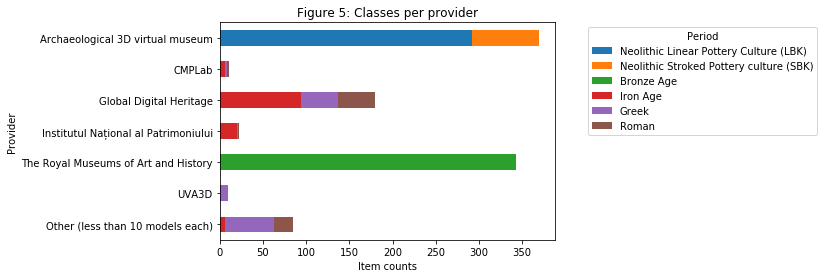

In [10]:
# for each provider, count items per period (class) 
classes_provider = []
for group in metadata_df.groupby('user.displayName'): # group by data provider (displayName is name of provider)
    counts = group[1].groupby('period')['period'].count().reindex(antiquity) # group by period, aggregate, sort by antiquity
    counts.name = group[0] 
    classes_provider.append(counts)
classes_provider = pd.DataFrame(classes_provider)

# make sure 'Other ...' is at the bottom
other = classes_provider.loc['Other (less than 10 models each)']
classes_provider.drop('Other (less than 10 models each)', inplace=True)
classes_provider = classes_provider.append(other)

# reverse order of provider names top to bottom, stack by period
classes_provider.iloc[::-1].plot.barh(stacked=True) 
plt.title('Figure 5: Classes per provider')
plt.xlabel('Item counts')
plt.ylabel('Provider')
plt.legend(title='Period', loc='upper right', bbox_to_anchor=(1.8, 1))
plt.show();

### Distribution of vertices

The metadata includes information on the number of vertices in each 3D-model. 

In [11]:
# get the data to plot
x = metadata_df['vertexCount']

print(
    'The number of vertices per 3D-model ranges from {} to {}. \n\
The median is {:.0f}, the mean is {:.0f}, the standard deviation is {:.0f}, \n\
95% of the 3D-models have more than {:.0f} vertices.'.format(
    x.min(), x.max(), x.median(), x.mean(), x.std(),
    x.quantile(0.05)
))

The number of vertices per 3D-model ranges from 860 to 3211002. 
The median is 250000, the mean is 281694, the standard deviation is 380816, 
95% of the 3D-models have more than 37476 vertices.


The median and the mean are not too far apart from each other, however the standard deviation is larger than the mean, which implies that the data is skewed. The range is a potential problem, because 3D-models with few vertices look different than those with many vertices: 
* 3D-models with very few vertices are probably not usable (fig. 6A)
* A very high vertex count (several million) gives the rendered models a blotched appearance (fig. 6B)
* Sub-sampling these 3D-models with very high vertex counts brings up more details (fig. 6C). 

<img src="fig/subsampled.png">

_Figure 6: The 3D-model with the least vertices (A), with the most vertices (B), the model with the most vertices sub-sampled to 37532 vertices (C)_

The frequency plot (fig. 6) shows that the distribution of vertex counts in not normally distributed, and that the median value is very pronounced. 

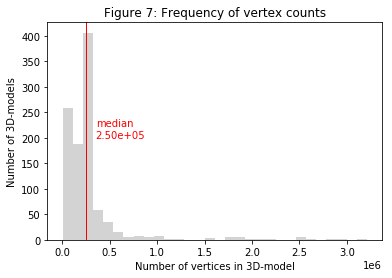

In [12]:
# plot bins
plt.hist(x, bins=30, color='lightgray')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0)) # x axis labels in scientific notation
# plot the median
median_val = x.median()
plt.axvline(median_val, color='red', linewidth=1)
plt.annotate('median\n{:.2e}'.format(median_val), (median_val+1e5, 200), color='red')
# title etc.
plt.title('Figure 7: Frequency of vertex counts')
plt.xlabel('Number of vertices in 3D-model')
plt.ylabel('Number of 3D-models')
plt.show();

Looking at the distribution of vertex counts __by data provider__ using box plots (fig. 8A) shows that data from the "Archaeological 3D virtual museum" - which is the largest data provider (tab. 2) - has very little variance. This is most probably an artifact of the digitization process. Unfortunately, no detailed documentation about the process is available on the Sketchfab website.

Looking at the distribution of vertex counts __by period__ (fig. 8B) shows that, as all the data for the Neolithic pots come from the "Archaeological 3D virtual museum", these data is affected by the same digitization artifacts, resulting in very little variance.

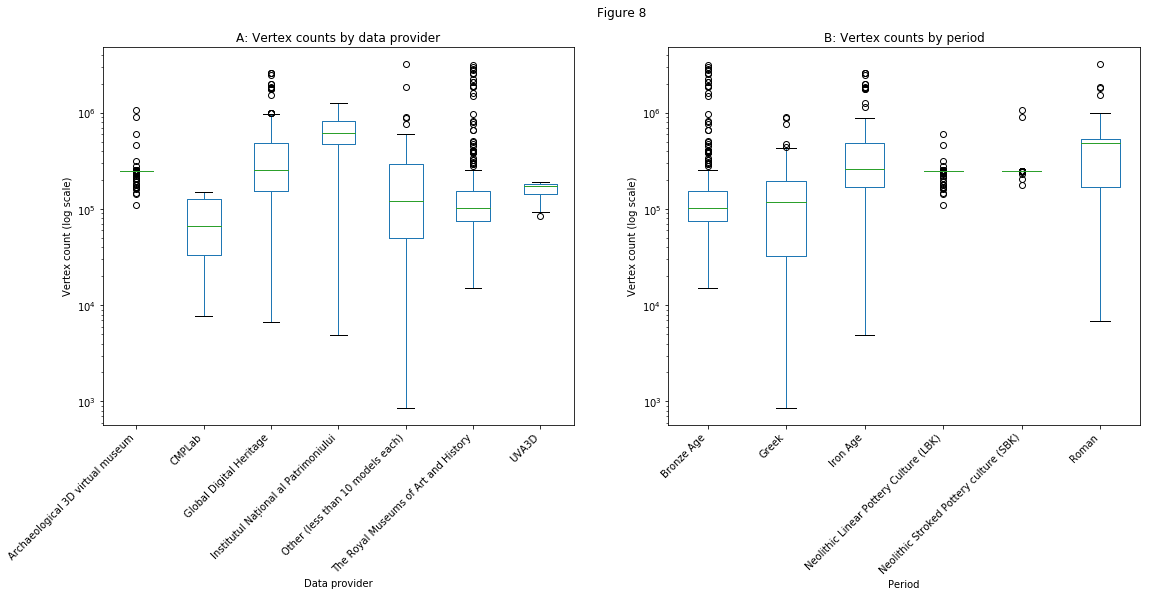

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# vertices by data provider
metadata_df.boxplot(ax=ax1, column='vertexCount', by='user.displayName', grid=False, rot=45, fontsize=10)
ax1.set_yscale("log")
ax1.set_xlabel('Data provider')
ax1.set_ylabel('Vertex count (log scale)')
ax1.set_title('A: Vertex counts by data provider')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# vertices by period
metadata_df.boxplot(ax=ax2, column='vertexCount', by='period', grid=False, rot=45, fontsize=10)
ax2.set_yscale("log")
ax2.set_xlabel('Period')
ax2.set_ylabel('Vertex count (log scale)')
ax2.set_title('B: Vertex counts by period')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

fig.suptitle('Figure 8')
plt.show();

### Handling outliers

I examined the distribution of the number of vertices in the 3D-models. 3D-models with few vertices look different than those with more vertices (fig. 6). 95% of the 3D-models have more than 37532 vertices. I propose to discard 3D-models with fewer than 37532 vertices, and to sub sample 37532 vertices from 3D-models that have more vertices.

In [14]:
q95_vertices = metadata_df['vertexCount'].quantile(0.05)
idx = metadata_df['vertexCount'] >= q95_vertices
print('This will result in a dataset with {} objects, with {:.0f} vertices each.'.format(len(metadata_df[idx]), q95_vertices))

This will result in a dataset with 969 objects, with 37476 vertices each.


Discarding 3D-models with few vertices changes the distribution of the number of 3D-models in each class (classes are Bronze Age, Iron Age etc.). Removing outliers does not affect the imbalance between classes (fig. 9). 

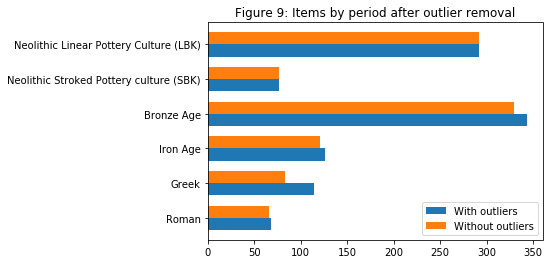

In [15]:
import numpy as np
import matplotlib.pyplot as plt

antiquity = [
    'Neolithic Linear Pottery Culture (LBK)', 'Neolithic Stroked Pottery culture (SBK)', 
    'Bronze Age', 'Iron Age', 'Greek', 'Roman']
N = len(antiquity)

# count 3D-models before outlier removal
counts_all = metadata_df['period'].value_counts()
counts_all = counts_all.reindex(antiquity).iloc[::-1] # reverse order top to bottom

# count 3D-models after outlier removal
counts_q95 = metadata_df.loc[idx, 'period'].value_counts()
counts_q95 = counts_q95.reindex(antiquity).iloc[::-1] # reverse order top to bottom

# draw plot
fig, ax = plt.subplots()
ind = np.arange(N)    # the x locations for the groups
height = 0.35         # the width of the bars
ax.barh(ind, counts_all, height, label='With outliers')
ax.barh(ind + height, counts_q95, height, label='Without outliers')

ax.set_title('Figure 9: Items by period after outlier removal')
ax.set_yticks(ind + height / 2)
ax.set_yticklabels(antiquity[::-1])
ax.legend()
plt.show();

After removing outliers, I saved the cleaned dataset to disk in the file `data/metadata.csv`.

In [16]:
# save the cleaned data to file
metadata_df[idx].to_csv(os.path.join('data', 'metadata.csv'), index=False)

## 3D-models
I obtained 3D-models from the [Sketchfab website](https://sketchfab.com/3d-models/categories/cultural-heritage-history?date=week&features=downloadable&licenses=322a749bcfa841b29dff1e8a1bb74b0b&licenses=b9ddc40b93e34cdca1fc152f39b9f375&licenses=72360ff1740d419791934298b8b6d270&licenses=bbfe3f7dbcdd4122b966b85b9786a989&licenses=2628dbe5140a4e9592126c8df566c0b7&licenses=34b725081a6a4184957efaec2cb84ed3&licenses=7c23a1ba438d4306920229c12afcb5f9&licenses=783b685da9bf457d81e829fa283f3567&licenses=5b54cf13b1a4422ca439696eb152070d&sort_by=-likeCount). Sketchfab provides an [API](https://docs.sketchfab.com/data-api/v3/index.html#!/models/get_v3_models_uid_download) for querying and downloading 3D-models. I contacted Sketchfab to check if it would be alright to download a large number of 3D-models. They have been very supportive to my idea and I managed to use the API to download all the metadata and the 3D-models. 
The API requires a Sketchfab account and a key. The key is stored in the file `client_credentials.json` (not included in the submission). Please note that:
* 3D-models are large files. The project should require an estimated 20 GB of data, 17 GB for the downloaded files alone. I setup a virtual storage with 50 GB to hold the data for this project. Github recommends keeping projects under 5 GB. Therefore I will not be able to upload the 3D-models as such to the capstone repository, but only the preprocessed files. 
* the Sketchfab API has various download rate restrictions (per day, per hour, per minute), so that the download process has to be extended over a period of several days.

The downloaded 3D-models are stored as zip-compressed files on an external disk. As explained above, this data is too large for GitHub.

In [17]:
import pandas as pd
import os

# reload the cleaned-up metadata
metadata_df = pd.read_csv(os.path.join('data', 'metadata.csv'), index_col=False)

# after attempting to download the models, it apperas that some 3D-models are unavailable
unavailable = ['90ed2b7744134172bc8a24e37431ad39']
available_idx = [uid not in unavailable for uid in metadata_df.id]
metadata_df = metadata_df[available_idx]

print('There are {} 3D-models in the dataset.'.format(metadata_df.shape[0]))

There are 968 3D-models in the dataset.


In [18]:
import json
import requests
import os
import time

# load credentials stored in local file
with open('client_credentials.json') as file:
    client_credentials = json.load(file)
API_TOKEN = client_credentials['api_token'] # Token from Sketchfab account

DOWNLOAD_DIR = '/mnt/Disk2/downloaded_models' # Folder to store the downloaded files
DOWNLOAD_DELAY = 20 # seconds, 200 / hour API rate limit
DOWNLOAD_ENDPOINT = 'https://api.sketchfab.com/v3/models/{}/download' # API endpoint

# HTTP request headers
headers = {'Authorization': 'Token {}'.format(API_TOKEN)} # Authorization method used
headers.update({'Content-Type': 'application/json'}) # http content type of the request

def download_data(uid):
    """
    Downloads a 3D-model from Sketchfab, saves it to a zipped file.
    @param: uid unique id of the model
    @raises: RequestException, e.g. API limit exceeded
    """
    # get the download url of the model
    # this url is only valid for a few minutes
    r = requests.get(
        DOWNLOAD_ENDPOINT.format(uid),
        headers = headers
    )
    r.raise_for_status() # throw exception if request status is not OK
    model_link = json.loads(r.text)
    url = model_link['gltf']['url'] # download url of the model

    # download the 3D-model, save it to file
    r = requests.get(url)
    with open(filename,'wb') as output_file:
        output_file.write(r.content)
            

try:
    # loop through the metadata table and download each 3D-model
    total = len(metadata_df)
    counter = 1
    verbose = False
    for model_uid in metadata_df['id']:
        filename = os.path.join(DOWNLOAD_DIR, '{}.zip'.format(model_uid)) # file to save the 3D-model
        if os.path.isfile(filename): # check that the file hasn't been downloaded already
            if verbose:
                print('File {} already exists'.format(filename))
        else:
            print('Downloading model {} ({}/{})'.format(model_uid, counter, total))
            download_data(model_uid) # download and save the 3D-model
            time.sleep(DOWNLOAD_DELAY) # don't hit the API too hard
        counter += 1

# Downloads may fail, typically when API limit exceeded
except requests.exceptions.RequestException:
    print('Download failed for 3D-model: {}'.format(model_uid))


In [19]:
print('The output of this step is: a folder with {} compressed files of 3D-models.'.format(
    len([
        name for name in os.listdir(DOWNLOAD_DIR) 
        if os.path.isfile(os.path.join(DOWNLOAD_DIR, name))
    ])
))

The output of this step is: a folder with 968 compressed files of 3D-models.
